https://ui.adsabs.harvard.edu/abs/2019A%26A...621A.122B/abstract

In [1]:
from astropy import units as u
distance = 2.2*u.kpc

In [2]:
cd /orange/adamginsburg/salt/beuther/

/orange/adamginsburg/salt/beuther


In [3]:
ls

core.python-8-1653072238-3663-3389-c0711a-s14.ufhpc.56877
core.python-8-1653072280-3663-3389-c0711a-s14.ufhpc.21418
disk1.reg
disk2.reg
G351disk1_NaCl_mom0_ticks.png
G351disk1_SiS13-12_mom0_ticks.png
G351disk2_NaCl_mom0_ticks.png
G351mm1_naclPV_withcolorcurves.png
G351mm1_PNPV_withcolorcurves.png
G351mm1_SiS1312PV_withcolorcurves.png
G351mm2_naclPV_withcolorcurves.png
G351_spw0_selfcal2_disk1.fits
G351_spw0_selfcal2_disk2.fits
G351_spw0_selfcal2.fits
G351_spw1_selfcal2_disk1.fits
G351_spw1_selfcal2_disk2.fits
G351_spw1_selfcal2.fits
G351_spw2_selfcal2_disk1.fits
G351_spw2_selfcal2_disk2.fits
G351_spw2_selfcal2.fits
G351_spw3_selfcal2_disk1.fits
G351_spw3_selfcal2_disk2.fits
G351_spw3_selfcal2.fits
NaCl_v_le_3_stackcube_disk1.fits
NaCl_v_le_3_stackcube_disk2.fits
spectra/
water_masked_moment0.fits


for fn in glob.glob("*.fits"):
    print('app

In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b64b9a89dc0>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [9]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('../sanhueza/G351.77/cutout.reg')
disk1 = regions.Regions.read('disk1.reg')
disk2 = regions.Regions.read('disk2.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

(1890.0, 2155.0, 1885.0, 2169.0)

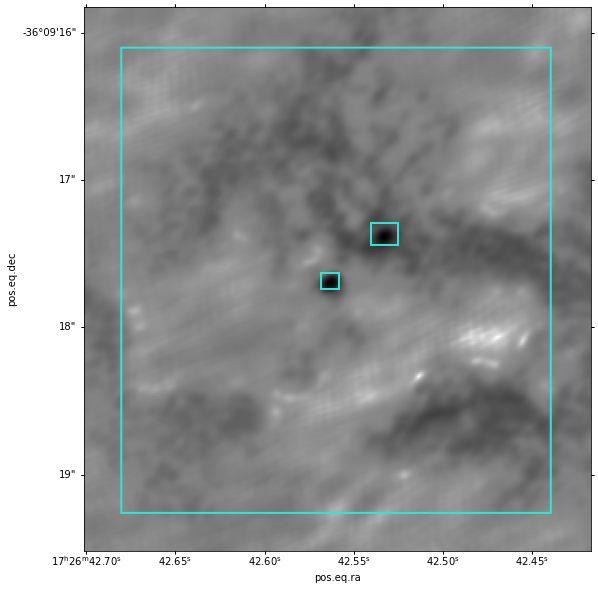

In [10]:
cont = SpectralCube.read('../sanhueza/G351.77/G351.77-0.54.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
disk1[0].to_pixel(cont[0].wcs).plot(ax=ax)
disk2[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [11]:
from spectral_cube.analysis_utilities import stack_cube

In [12]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [13]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [14]:
flist = (glob.glob('G351_spw[0123]_selfcal2.fits'))

In [15]:
flist

['G351_spw2_selfcal2.fits',
 'G351_spw0_selfcal2.fits',
 'G351_spw1_selfcal2.fits',
 'G351_spw3_selfcal2.fits']

In [16]:
#from dask.diagnostics import ProgressBar
#pbar = ProgressBar()
#pbar.register()

import dask
dask.config.set(scheduler='threads', num_workers=8)

In [17]:
for fn in flist:
    for rr,regn in ((disk1, 'disk1'), (disk2, 'disk2')):
        outfile = fn.replace(".fits",f"_{regn}.fits")
        if not os.path.exists(outfile) or (os.path.exists(outfile) and (SpectralCube.read(outfile).unit != u.K) or hasattr(SpectralCube.read(outfile), 'beams')):
            cube = SpectralCube.read(fn, use_dask=True).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            if hasattr(cube, 'beams'):
                with cube.use_dask_scheduler('threads', num_workers=8):
                    cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
                    scube = cube.convolve_to(cb, save_to_tmp_dir=True)
            else:
                scube = cube
            assert not hasattr(scube, 'beams')
            scube.allow_huge_operations = True
            scube.to(u.K).write(outfile, overwrite=True)            

In [18]:
regn = "disk1"
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'G351_spw[0123]_selfcal2_{regn}.fits'))]
cubes

[DaskSpectralCube with shape=(864, 30, 37) and unit=K and chunk size (864, 30, 37):
  n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
  n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
  n_s:    864  type_s: VRAD      unit_s: m / s  range: -1310819.594 m / s: 1278180.406 m / s,
 DaskSpectralCube with shape=(400, 30, 37) and unit=K and chunk size (400, 30, 37):
  n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
  n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
  n_s:    400  type_s: VRAD      unit_s: m / s  range: -1213178.195 m / s: 1180821.805 m / s,
 DaskSpectralCube with shape=(404, 30, 37) and unit=K and chunk size (404, 30, 37):
  n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
  n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
  n_s:    404  type_s: VRA

In [19]:
regn = "disk2"
cubesd2 = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'G351_spw[0123]_selfcal2_{regn}.fits'))]
cubesd2

[DaskSpectralCube with shape=(429, 22, 26) and unit=K and chunk size (429, 22, 26):
  n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
  n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
  n_s:    429  type_s: VRAD      unit_s: m / s  range:  -658149.557 m / s:  625850.443 m / s,
 DaskSpectralCube with shape=(864, 22, 26) and unit=K and chunk size (864, 22, 26):
  n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
  n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
  n_s:    864  type_s: VRAD      unit_s: m / s  range: -1310819.594 m / s: 1278180.406 m / s,
 DaskSpectralCube with shape=(400, 22, 26) and unit=K and chunk size (400, 22, 26):
  n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
  n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
  n_s:    400  type_s: VRA

In [20]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
                                    if hasattr(cube, 'beams')
                                    else cube.beam
                                    for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()

In [21]:
cb

Beam: BMAJ=0.0521559901535508 arcsec BMIN=0.03773447871208164 arcsec BPA=61.88432693481445 deg

In [22]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 114.74317834 AU>

In [23]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 83.01585317 AU>

In [24]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.with_spectral_unit(u.GHz).spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.with_spectral_unit(u.GHz).spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.with_spectral_unit(u.GHz).spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.with_spectral_unit(u.GHz).spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 232.509977] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=18-17'], dtype='<U24'))

In [25]:
from astropy import log
log.setLevel('INFO')

In [26]:
#log.setLevel('DEBUG')
vcen = -3.6 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-35*u.km/u.s,
                   vmax=vcen+35*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.to(u.K).write('NaCl_v_le_3_stackcube_disk1.fits', overwrite=True)

In [27]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube_disk1.fits', use_dask=True)
stackc

DaskSpectralCube with shape=(24, 30, 37) and unit=K and chunk size (24, 30, 37):
 n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
 n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
 n_s:     24  type_s: VRAD      unit_s: km / s  range:      -37.481 km / s:      31.483 km / s

In [28]:
#log.setLevel('DEBUG')
vcen = -3.6 * u.km/u.s # from Patricio
stack2, cutouts2 = stack_cube(cubesd2,
                   linelist=linelist,
                   vmin=vcen-25*u.km/u.s,
                   vmax=vcen+25*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack2.to(u.K).write('NaCl_v_le_3_stackcube_disk2.fits', overwrite=True)

In [29]:
pixscale_au = (np.abs((wcs.utils.proj_plane_pixel_area(stackc.wcs.celestial)**0.5*u.deg).to(u.arcsec)) * distance).to(u.au, u.dimensionless_angles())
pixscale_au

<Quantity 11. AU>

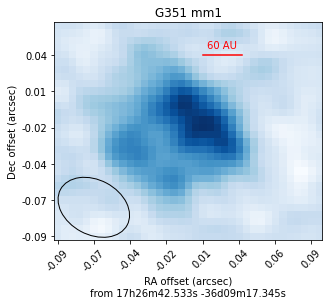

In [30]:
m0 = stackc[:,:,:].moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

dp_60 = (60*u.au / pixscale_au).decompose()

pl.title("G351 mm1")
pl.plot([20, 20+dp_60], [25,25], color='r')
pl.text(20 + dp_60/2, 26, f'60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xc,yc = 18,18

xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xtlocs-xc)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-yc)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)

offset_loc = m0.wcs.celestial.pixel_to_world(xc,yc)


ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("G351disk1_NaCl_mom0_ticks.png", bbox_inches='tight', dpi=300)

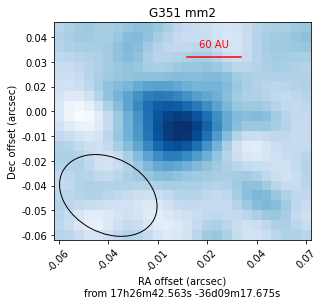

In [31]:
m0 = stack2[:,:,:].moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

pl.title("G351 mm2")
#pl.plot([13, 18], [18,18], color='r')
#pl.text(15.5, 19, f'{int(5*pixscale_au.value):0d} AU', horizontalalignment='center', color='r')
pl.plot([13, 13+dp_60], [18,18], color='r')
pl.text(13 + dp_60/2, 19, f'60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xc,yc = 12,12
xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xtlocs-xc)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-yc)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = stack2.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)


offset_loc = m0.wcs.celestial.pixel_to_world(xc,yc)

ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("G351disk2_NaCl_mom0_ticks.png", bbox_inches='tight', dpi=300)

DaskSpectralCube with shape=(404, 30, 37) and unit=K and chunk size (404, 30, 37):
 n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
 n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
 n_s:    404  type_s: VRAD      unit_s: m / s  range: -1222698.323 m / s: 1195301.677 m / s
DaskSpectralCube with shape=(7, 30, 37) and unit=K and chunk size (7, 30, 37):
 n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
 n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
 n_s:      7  type_s: VRAD      unit_s: km / s  range:      -22.402 km / s:      13.574 km / s


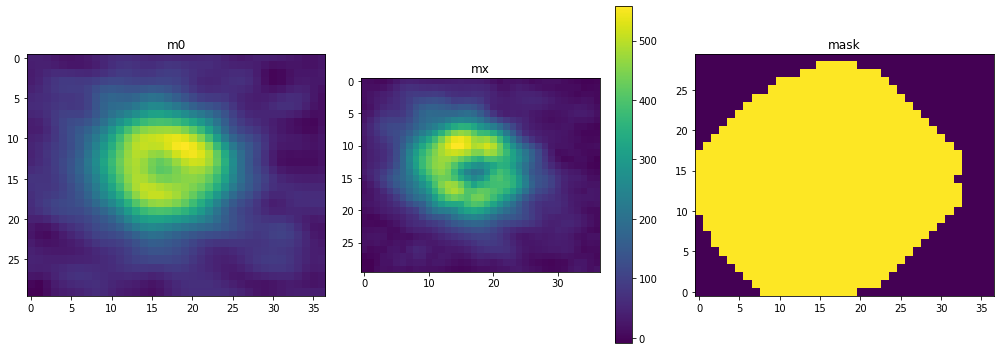

<Figure size 432x288 with 0 Axes>

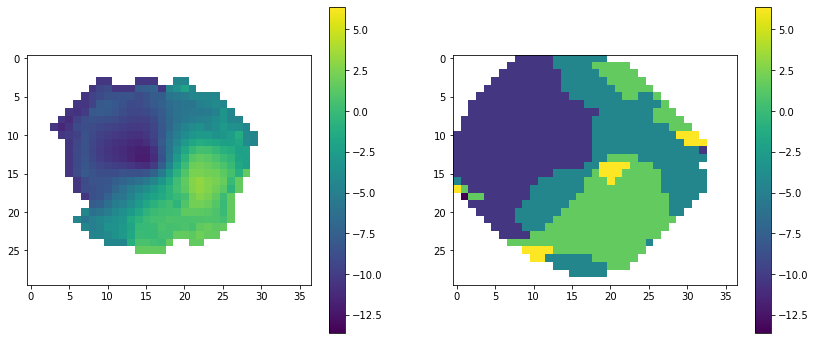

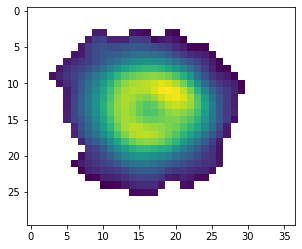

In [32]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.with_spectral_unit(u.GHz).spectral_extrema[0] < restval) & (c.with_spectral_unit(u.GHz).spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(disk1)
         .with_spectral_unit(u.GHz)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 150*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=7)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 40*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
m0m = scube.with_mask(msk).with_mask(m3d).moment0()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar()

pl.figure()
pl.imshow(m0m.value)
m0m.hdu.writeto('water_masked_moment0.fits', overwrite=True)

vmap = m1.hdu

DaskSpectralCube with shape=(404, 22, 26) and unit=K and chunk size (404, 22, 26):
 n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
 n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
 n_s:    404  type_s: VRAD      unit_s: m / s  range: -1222698.323 m / s: 1195301.677 m / s
DaskSpectralCube with shape=(8, 22, 26) and unit=K and chunk size (8, 22, 26):
 n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
 n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
 n_s:      8  type_s: VRAD      unit_s: km / s  range:      -28.398 km / s:      13.574 km / s


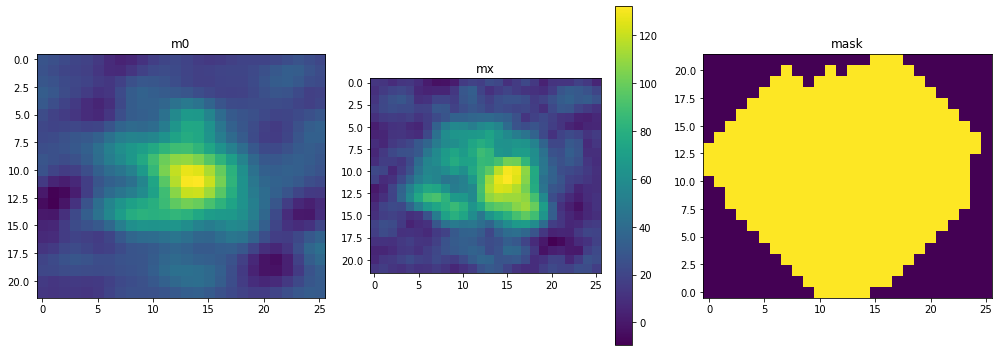

<Figure size 432x288 with 0 Axes>

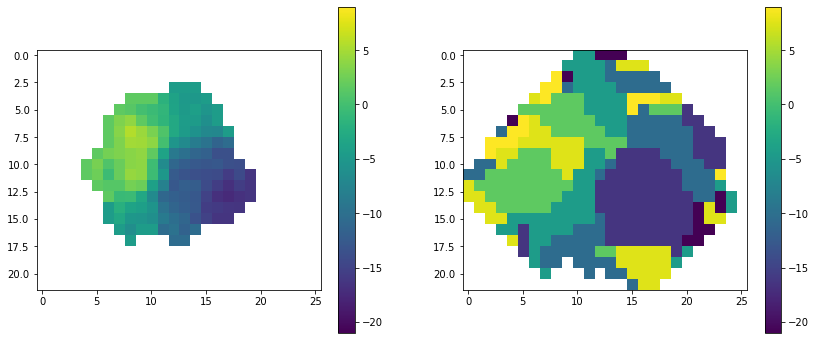

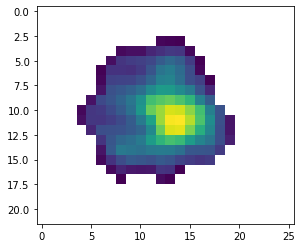

In [33]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
vcen2 = -6*u.km/u.s
cube = [c for c in cubesd2 if (c.with_spectral_unit(u.GHz).spectral_extrema[0] < restval) & (c.with_spectral_unit(u.GHz).spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(disk2)
         .with_spectral_unit(u.GHz)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen2, 20*u.km/u.s+vcen2))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 50*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=2)
msk = scipy.ndimage.binary_dilation(msk, iterations=7)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 25*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
m0m = scube.with_mask(msk).with_mask(m3d).moment0()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen2.value-15, vmax=vcen2.value+15)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen2.value-15, vmax=vcen2.value+15)
pl.colorbar()


pl.figure()
pl.imshow(m0m.value)

vmap2 = m1.hdu

In [34]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
import imp, overplot_saltlines; imp.reload(overplot_saltlines)
from overplot_saltlines import overplot_saltlines

In [35]:
import imp
import overplot_saltlines
imp.reload(overplot_saltlines)
import lines
imp.reload(lines)
from overplot_saltlines import overplot_saltlines, all_lines, linetexnames, linefreqs
'SO65-54' in all_lines, 'H30a' in all_lines, 'H30$\\alpha$' in linetexnames

(True, True, True)

In [36]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(disk1).with_spectral_unit(u.GHz).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'G351.77 mm1 spw{ii+1}'

In [37]:
spectra2 = []
for ii,cube in enumerate(cubesd2):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(disk2).with_spectral_unit(u.GHz).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra2.append(pysp)
    pysp.specname = f'G351.77 mm2 spw{ii+1}'

In [38]:
mkdir -p spectra/figures/disk1

In [39]:
mkdir -p spectra/figures/disk2

G351.77_mm1_spw1
G351.77_mm1_spw2
G351.77_mm1_spw3
G351.77_mm1_spw4


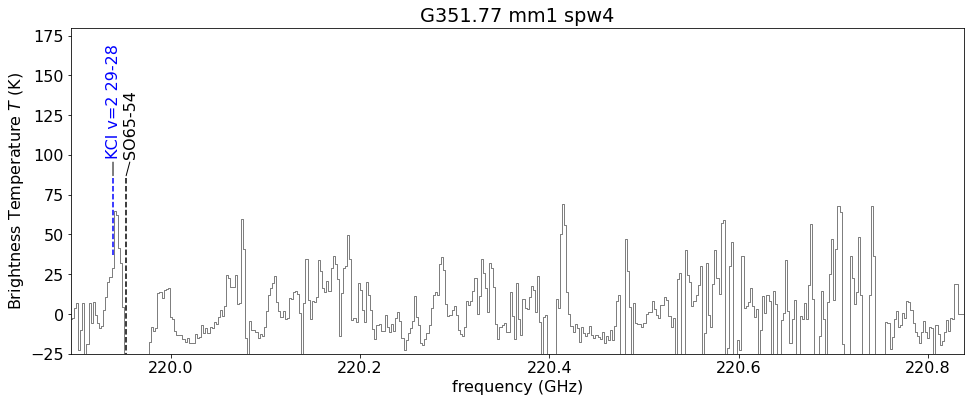

In [40]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures/disk1', ymax=180, ymin=-25, yfrac=0.6)

G351.77_mm2_spw1
G351.77_mm2_spw2
G351.77_mm2_spw3
G351.77_mm2_spw4


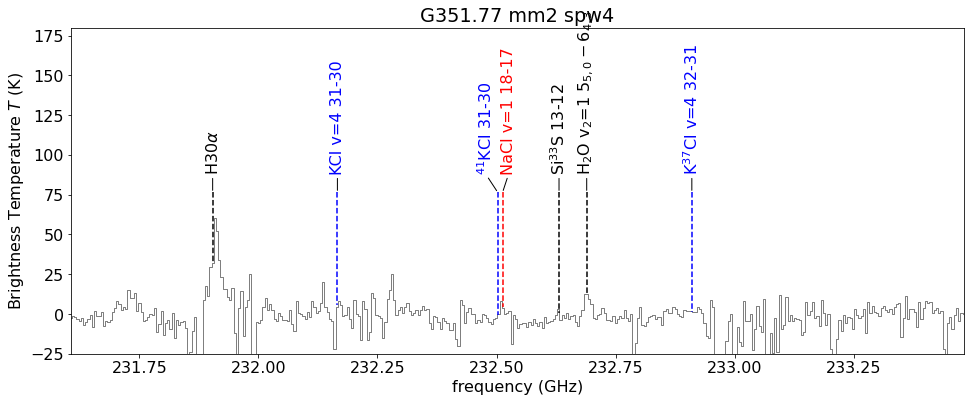

In [41]:
overplot_saltlines(spectra2, vcen=vcen, savepath='spectra/figures/disk2', ymax=180, ymin=-25, yfrac=0.55)

In [42]:
from IPython.display import Image,display

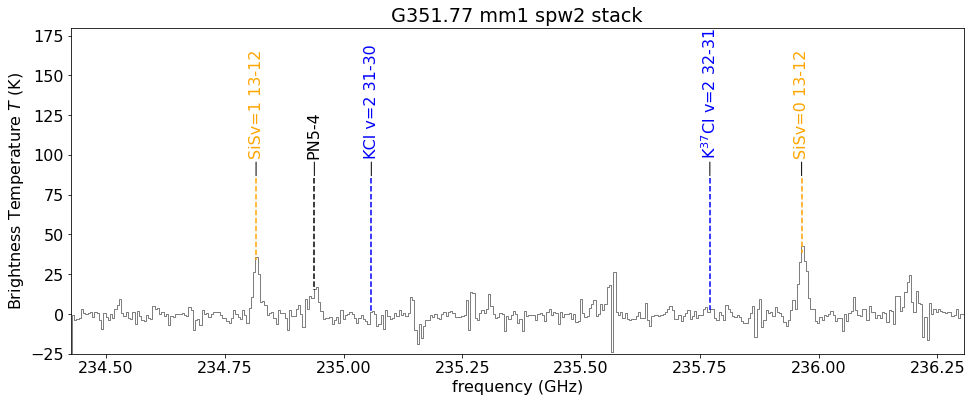

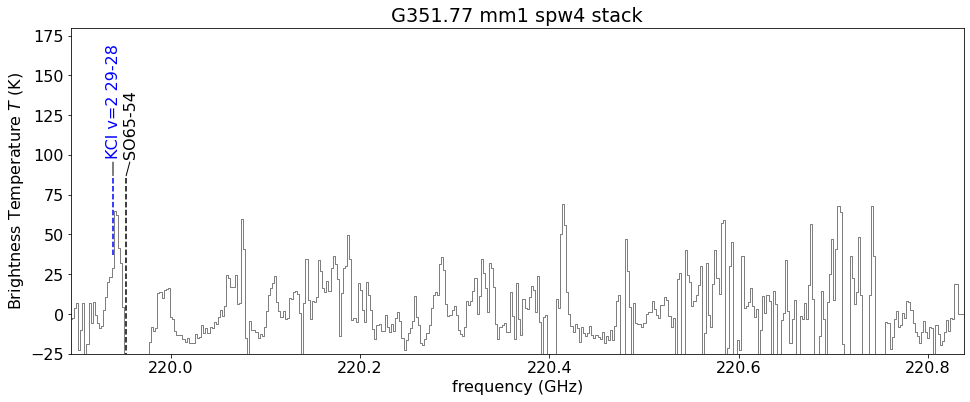

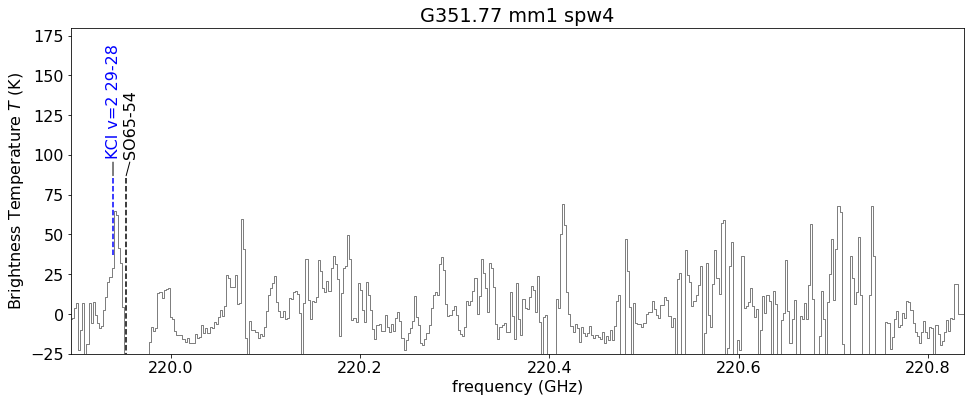

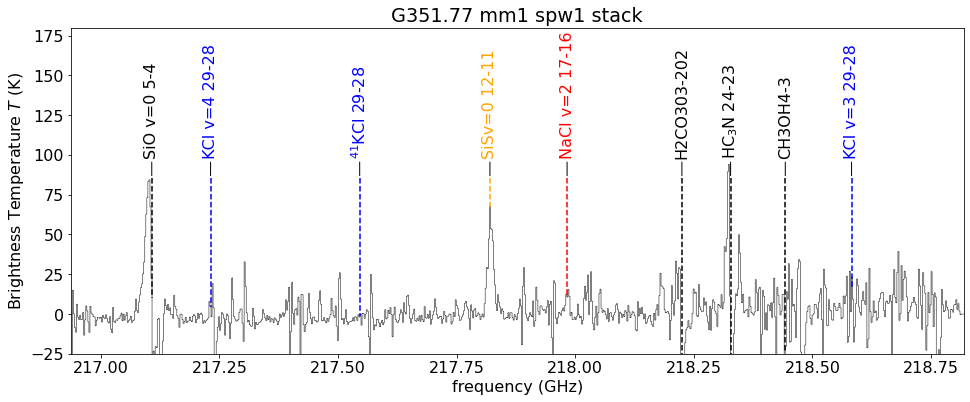

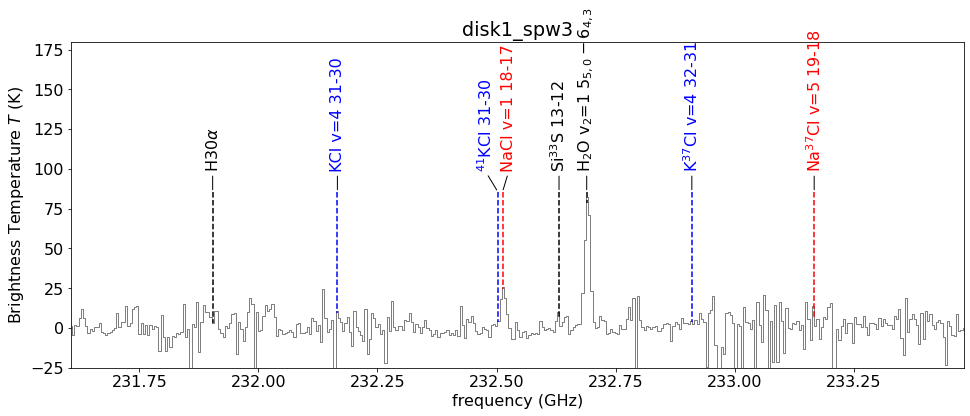

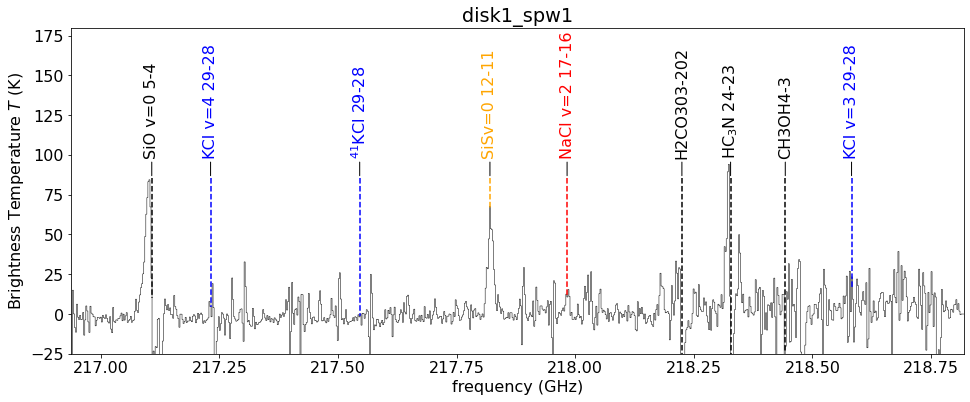

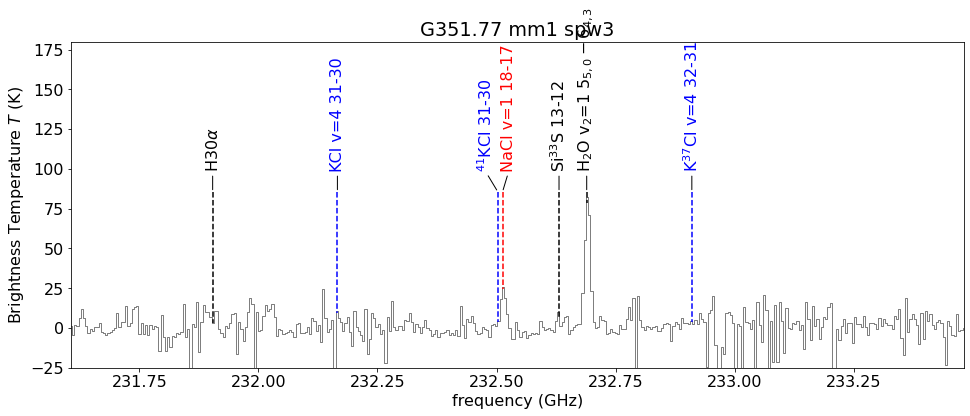

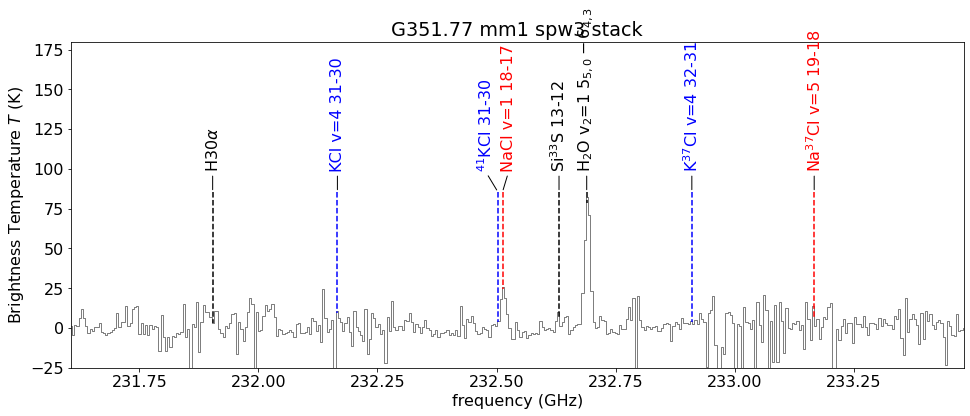

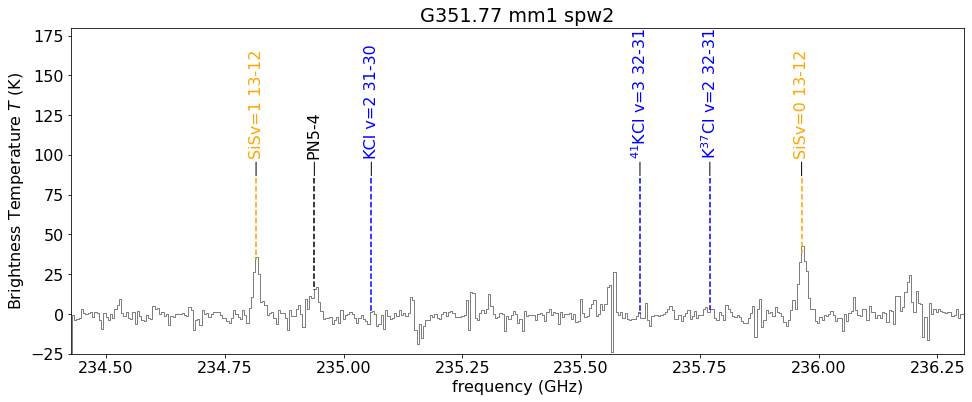

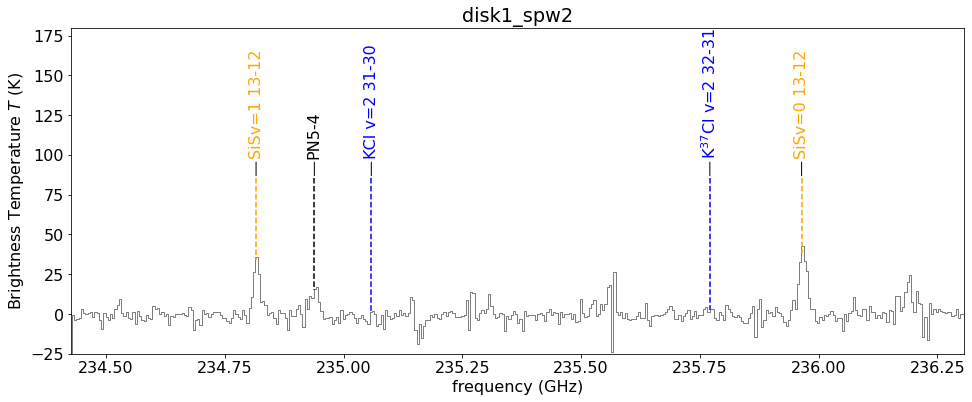

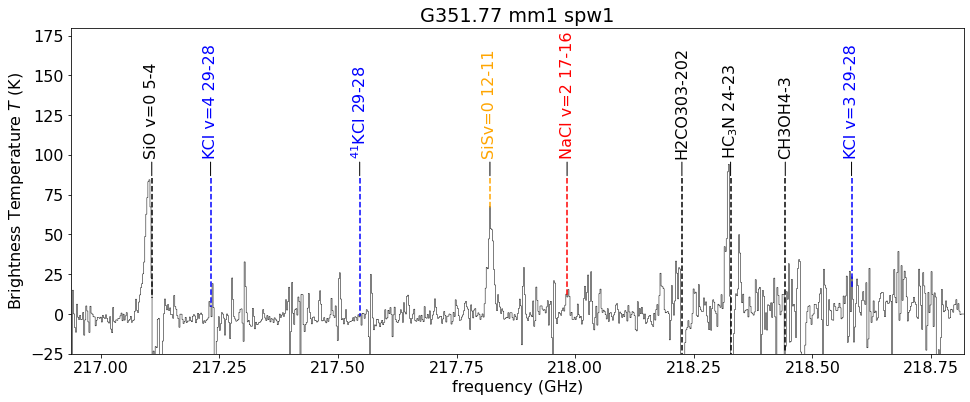

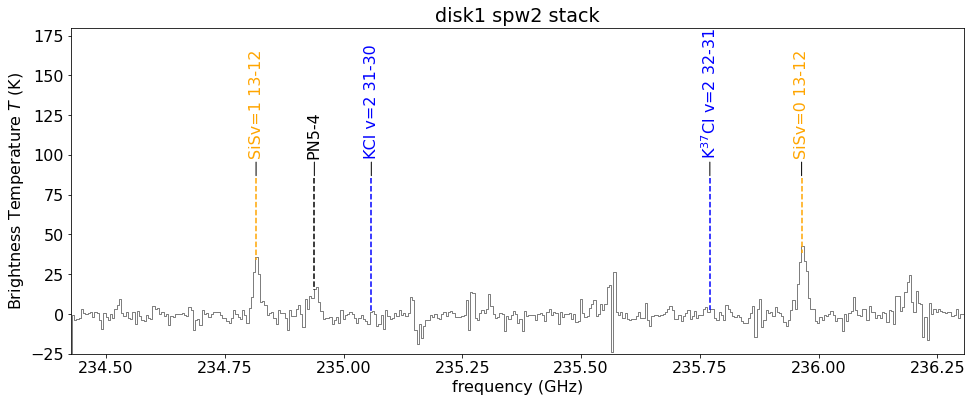

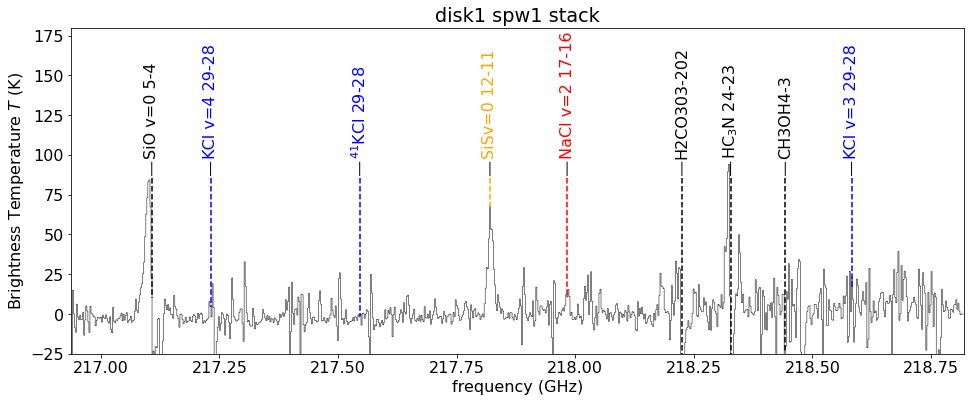

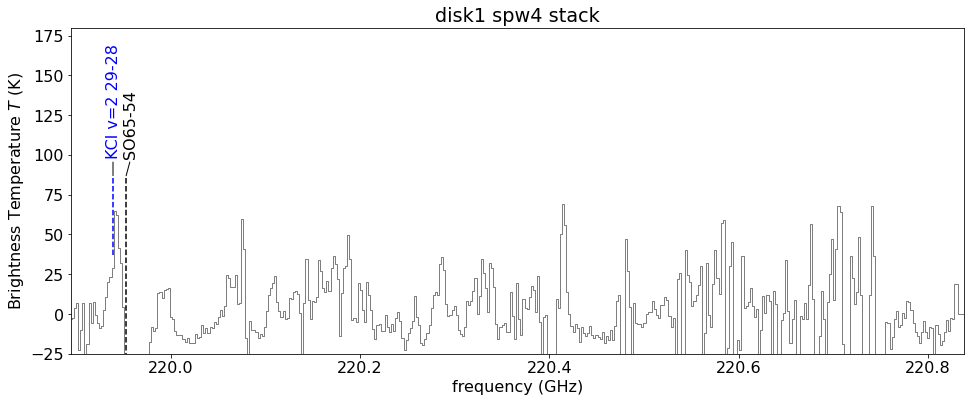

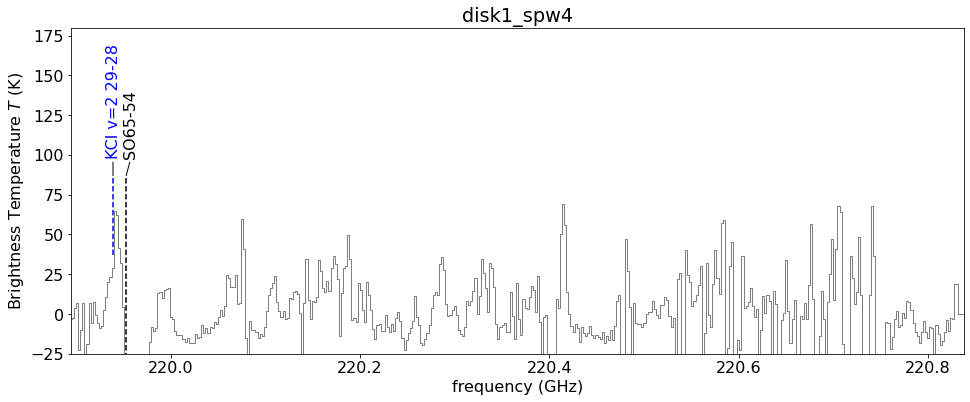

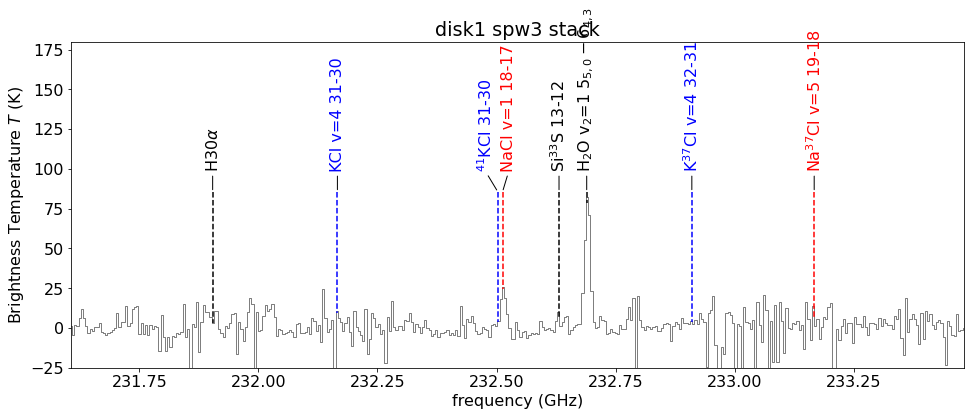

In [43]:
for fn in glob.glob('spectra/figures/disk1/color*png'):
    display(Image(fn))

In [44]:
pwd

'/orange/adamginsburg/salt/beuther'

In [45]:
ls $PWD/spectra/figures/disk2/color*png

/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw1.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw1_stack.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw2.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw2_stack.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw3.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw3_stack.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw4.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_disk2_spw4_stack.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_G351.77_mm2_spw1.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_G351.77_mm2_spw1_stack.png
/orange/adamginsburg/salt/beuther/spectra/figures/disk2/color_labels_G351.77_mm2_spw2.png
/orange/adamginsburg/salt/be

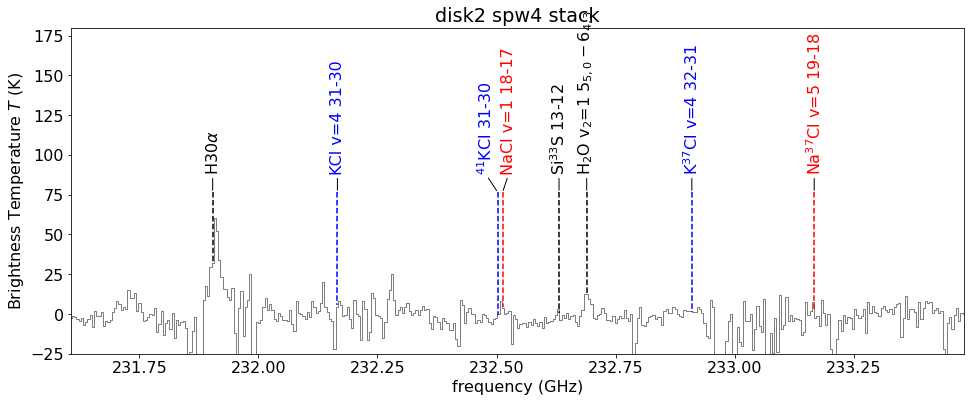

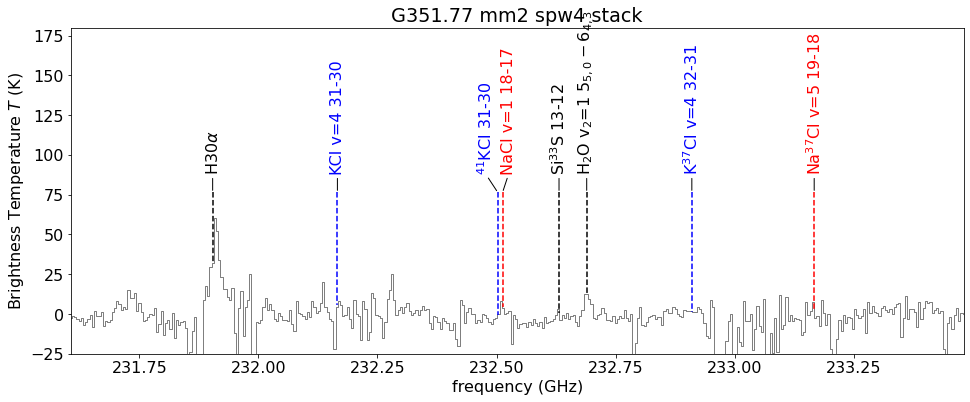

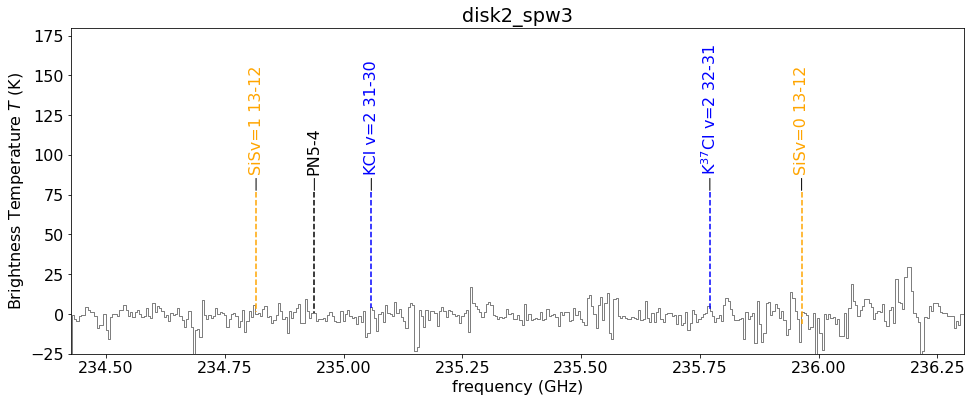

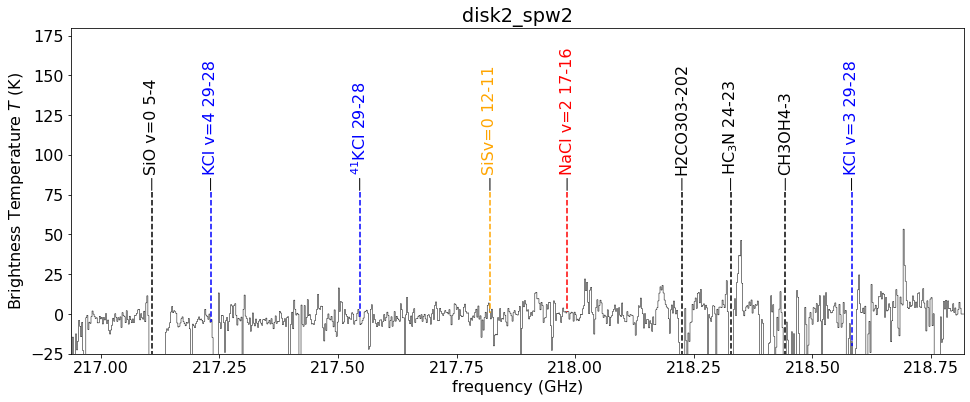

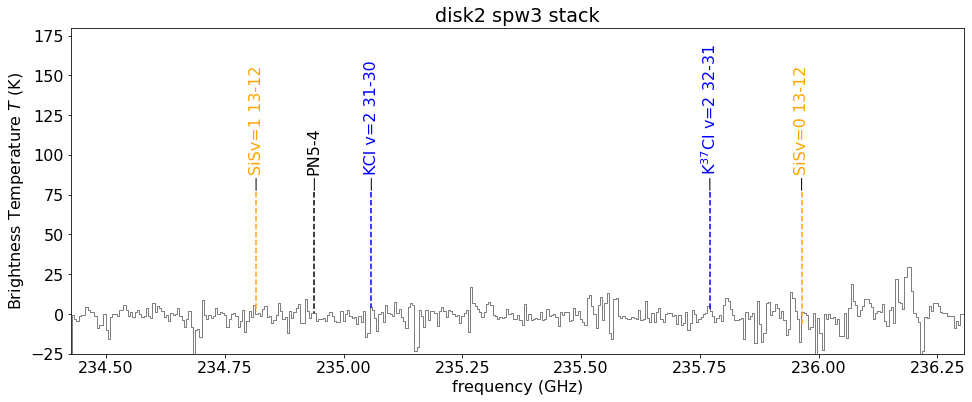

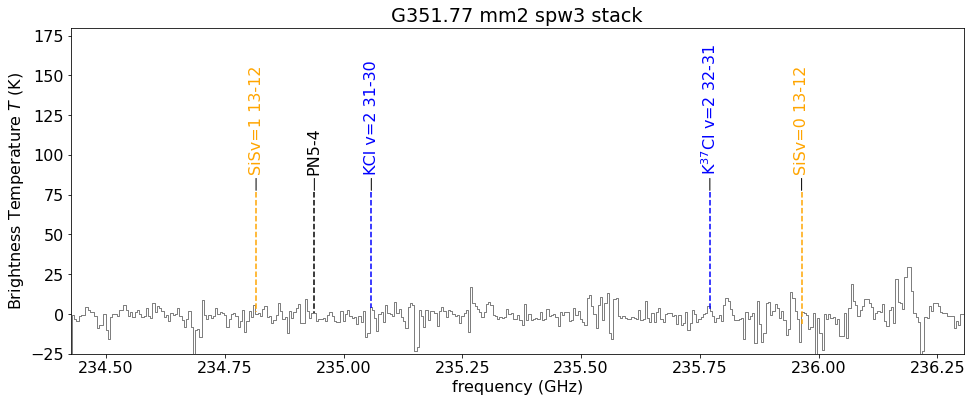

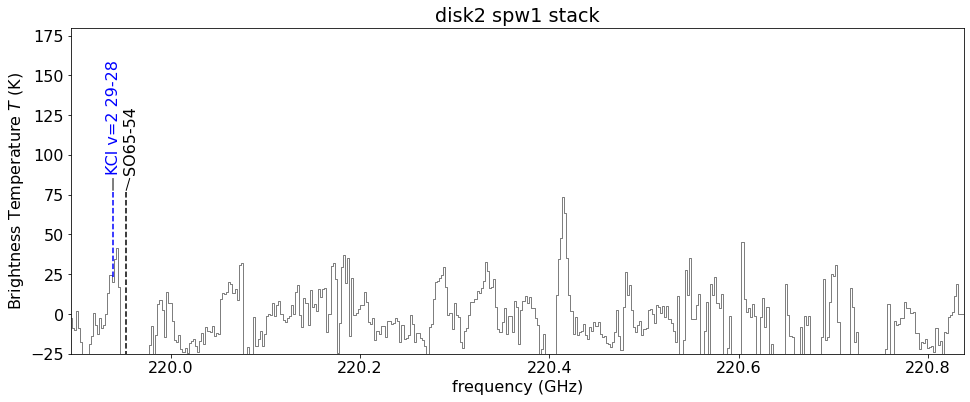

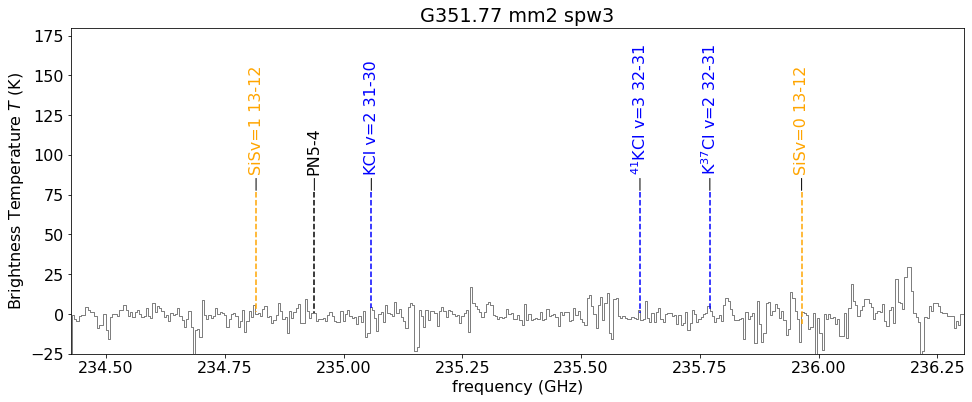

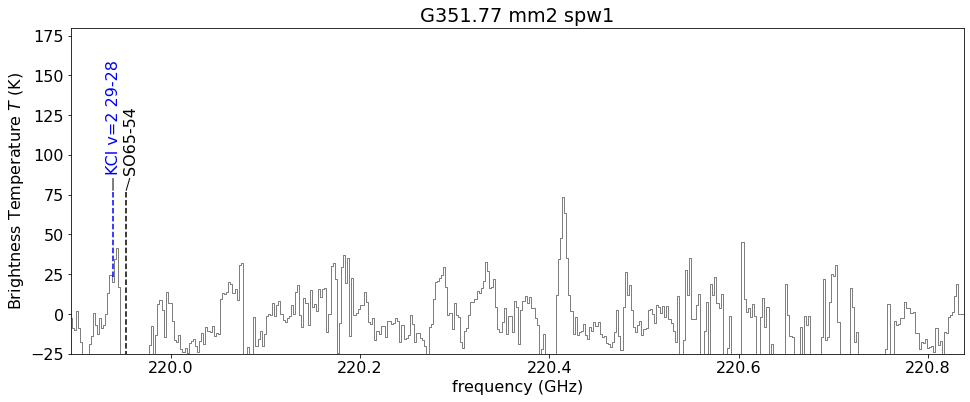

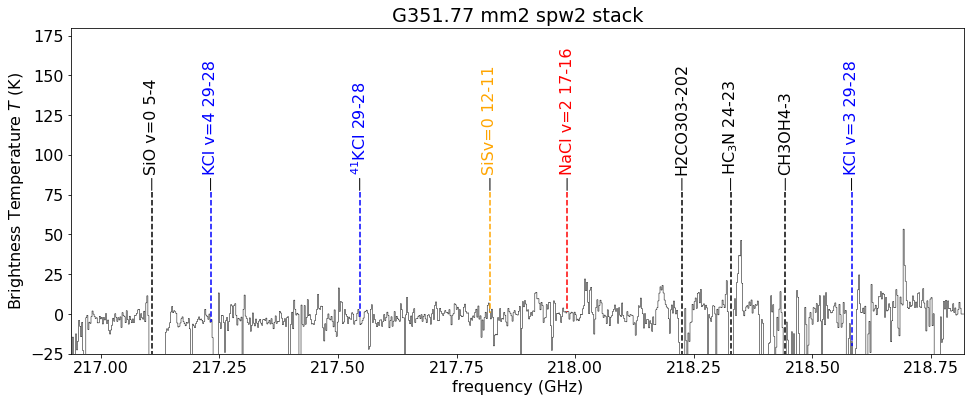

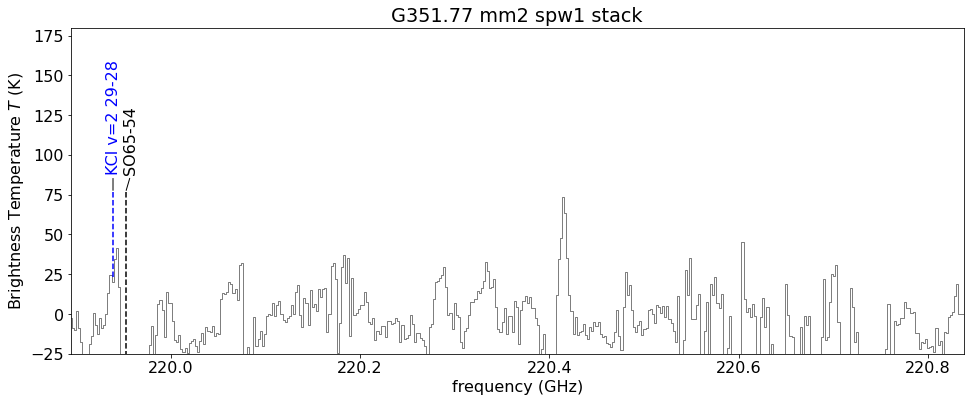

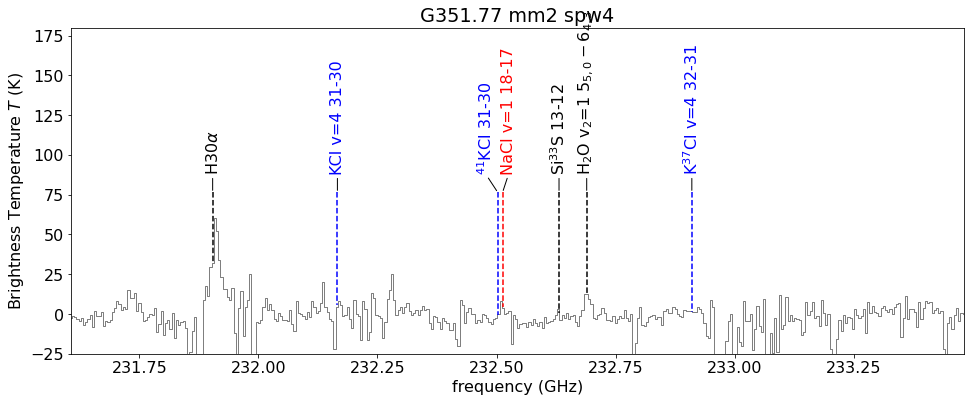

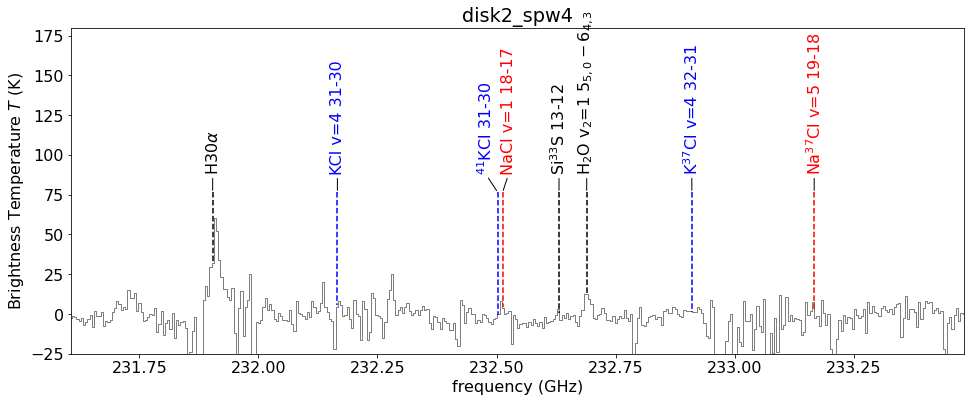

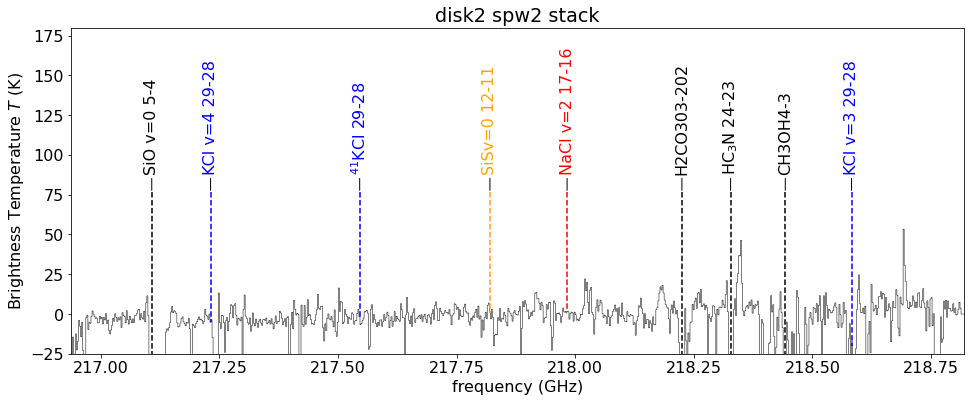

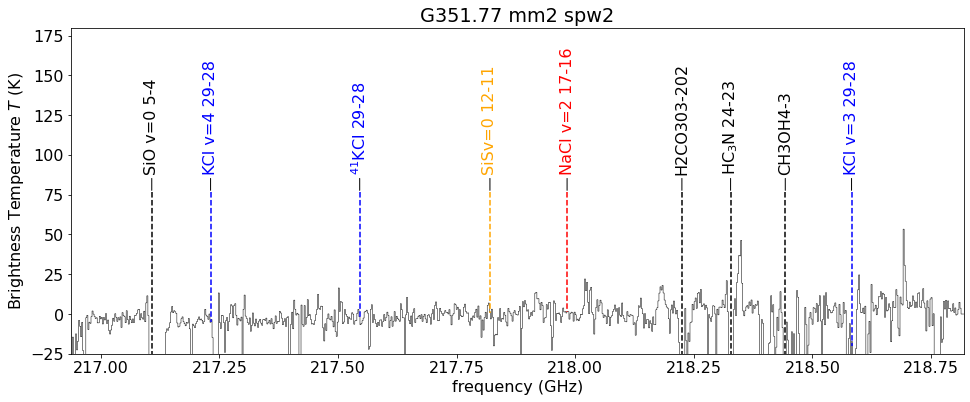

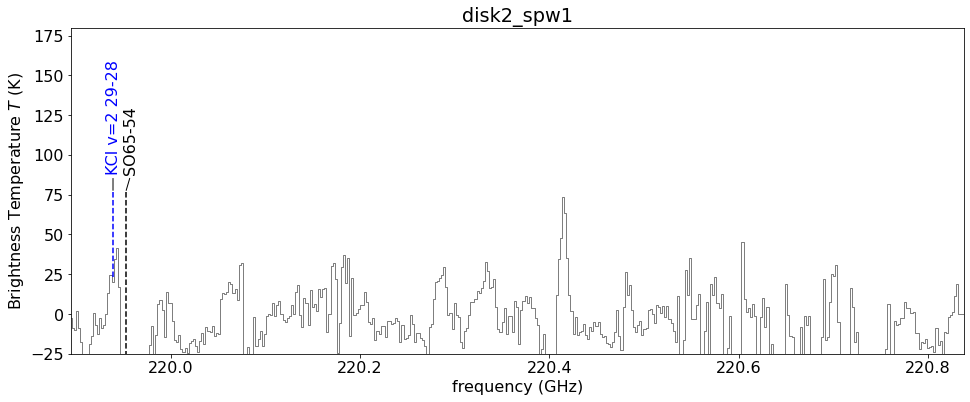

In [46]:
for fn in glob.glob('spectra/figures/disk2/color*png'):
    display(Image(fn))

disk1
DaskSpectralCube with shape=(864, 30, 37) and unit=K and chunk size (864, 30, 37):
 n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
 n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
 n_s:    864  type_s: VRAD      unit_s: m / s  range: -1310819.594 m / s: 1278180.406 m / s
Mean spectrum
Stacking


DaskSpectralCube with shape=(400, 30, 37) and unit=K and chunk size (400, 30, 37):
 n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
 n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
 n_s:    400  type_s: VRAD      unit_s: m / s  range: -1213178.195 m / s: 1180821.805 m / s
Mean spectrum


Stacking
DaskSpectralCube with shape=(404, 30, 37) and unit=K and chunk size (404, 30, 37):
 n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
 n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
 n_s:    404  type_s: VRAD      unit_s: m / s  range: -1222698.323 m / s: 1195301.677 m / s
Mean spectrum
Stacking


DaskSpectralCube with shape=(429, 30, 37) and unit=K and chunk size (429, 30, 37):
 n_x:     37  type_x: RA---SIN  unit_x: deg    range:   261.677189 deg:  261.677251 deg
 n_y:     30  type_y: DEC--SIN  unit_y: deg    range:   -36.154843 deg:  -36.154803 deg
 n_s:    429  type_s: VRAD      unit_s: m / s  range:  -658149.557 m / s:  625850.443 m / s
Mean spectrum


Stacking
disk2
DaskSpectralCube with shape=(429, 22, 26) and unit=K and chunk size (429, 22, 26):
 n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
 n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
 n_s:    429  type_s: VRAD      unit_s: m / s  range:  -658149.557 m / s:  625850.443 m / s
Mean spectrum


Stacking
DaskSpectralCube with shape=(864, 22, 26) and unit=K and chunk size (864, 22, 26):
 n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
 n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
 n_s:    864  type_s: VRAD      unit_s: m / s  range: -1310819.594 m / s: 1278180.406 m / s
Mean spectrum
Stacking


DaskSpectralCube with shape=(400, 22, 26) and unit=K and chunk size (400, 22, 26):
 n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
 n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
 n_s:    400  type_s: VRAD      unit_s: m / s  range: -1213178.195 m / s: 1180821.805 m / s
Mean spectrum


Stacking
DaskSpectralCube with shape=(404, 22, 26) and unit=K and chunk size (404, 22, 26):
 n_x:     26  type_x: RA---SIN  unit_x: deg    range:   261.677325 deg:  261.677368 deg
 n_y:     22  type_y: DEC--SIN  unit_y: deg    range:   -36.154926 deg:  -36.154897 deg
 n_s:    404  type_s: VRAD      unit_s: m / s  range: -1222698.323 m / s: 1195301.677 m / s
Mean spectrum
Stacking


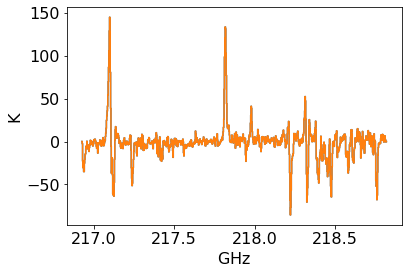

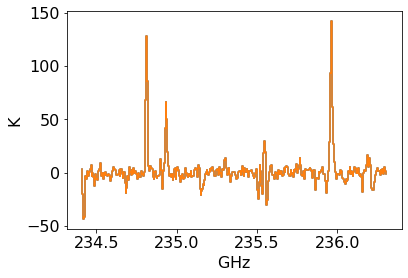

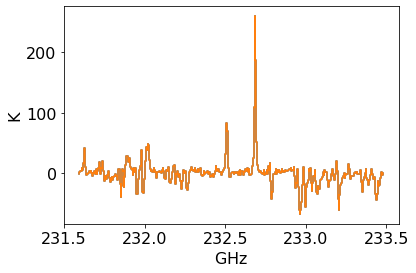

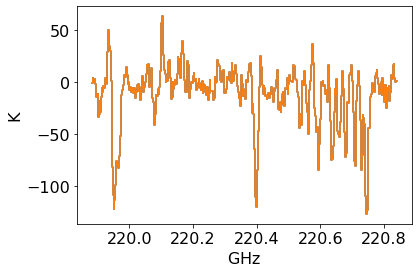

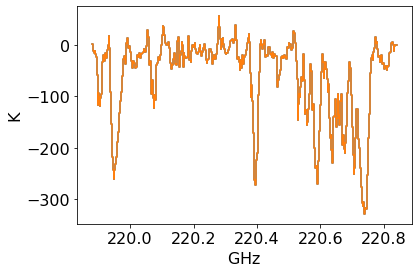

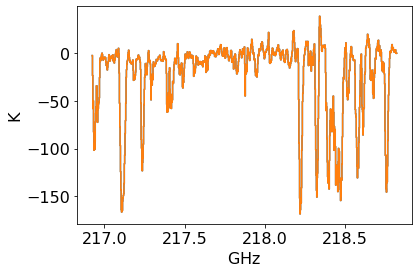

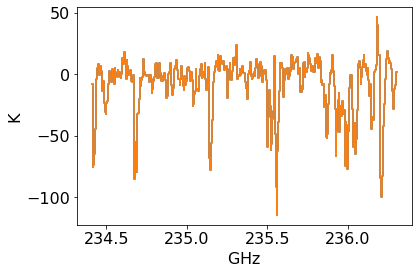

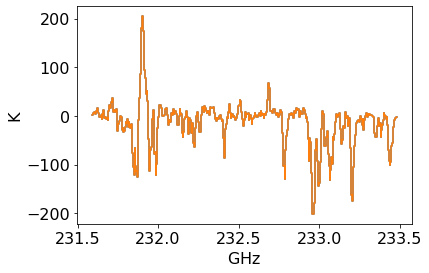

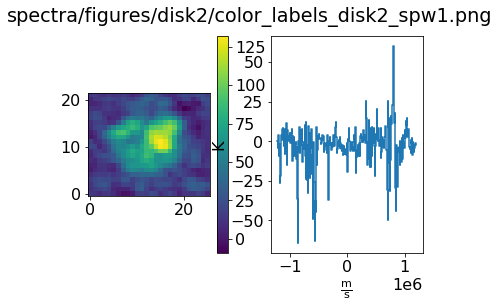

In [47]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm

for reg, cubelist, basename, vm in zip((disk1, disk2), (cubes, cubesd2), ('disk1', 'disk2'), (vmap, vmap2)):
    print(basename)
    for spwn,cube in enumerate(cubelist):
        print(cube)
        scube = cube.subcube_from_regions(reg).to(u.K)
        # continuum subtract before stacking
        #scube = scube - scube.percentile(25, axis=0)
        #mx = scube.max(axis=0)
        #msk = mx > 0.003*mx.unit
        print("Mean spectrum")
        sp = scube.mean(axis=(1,2))

        #sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


        # reproject the velocity map into the cube's coordinate system
        vmap_proj,_ = reproject.reproject_interp(vm,
                                                 scube.wcs.celestial,
                                                 shape_out=scube.shape[1:])
        vmap_proj = u.Quantity(vmap_proj, u.km/u.s)

        # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
        if scube.spectral_axis.unit.is_equivalent(u.Hz):
            scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

        print("Stacking")
        # perform the stacking!
        stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                               v0=0.0*u.km/u.s,
                                                               #progressbar=tqdm,
                                                               #num_cores=8
                                                              )
        fstack = stack.with_spectral_unit(u.GHz)

        pl.suptitle(f"{fn}")
        fstack.write(f'spectra/{basename}_{spwn}_stack.fits', overwrite=True)

        pl.clf()
        fstack.quicklook(filename=f'spectra/figures/{basename}_{spwn}_stack.pdf')
        fstack.quicklook(filename=f'spectra/figures/{basename}_{spwn}_stack.png')


        fig = pl.figure()
        mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
        pl.colorbar(mappable)
        pl.subplot(1,2,2)
        pl.suptitle(fn)
        sp.quicklook()

In [48]:
ls spectra

disk1_0_stack.fits  disk1_3_stack.fits  disk2_2_stack.fits
disk1_1_stack.fits  disk2_0_stack.fits  disk2_3_stack.fits
disk1_2_stack.fits  disk2_1_stack.fits  figures/


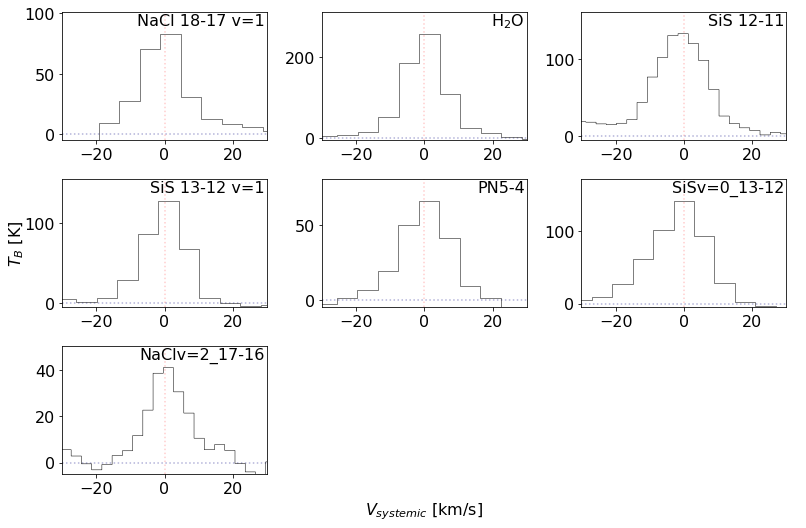

In [49]:
def line_zooms(globstr, linelist, gridshape=(3,3), vcen=0*u.km/u.s, dv=10*u.km/u.s, ymin=None):

    spectra = [pyspeckit.Spectrum(fn) for fn in glob.glob(globstr)]
    
    fig = pl.gcf()
    
    ax0 = fig.add_subplot(111, frameon=False)
    ax0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax0.set_ylabel("$T_B$ [K]")
    ax0.set_xlabel("$V_{systemic}$ [km/s]")

    plotnum = 1
    for linename, linefreq in linelist.items():
        for sp in spectra:
            if sp.xarr.in_range(linefreq):
                ax = fig.add_subplot(*gridshape, plotnum)
                sp.xarr.convert_to_unit(u.km/u.s, refX=linefreq)
                sp.plotter(axis=ax, xmin=vcen-dv, xmax=vcen+dv, ymin=ymin)
                ax.text(0.99, 0.9, linename, transform=ax.transAxes, ha='right')
                ax.axvline(vcen.value, color='r', linestyle=':', alpha=0.2)
                ax.axhline(0, color='navy', linestyle=':', zorder=-5, alpha=0.3)
                ax.set_xlabel("")
                ax.set_ylabel("")
                sp.xarr.convert_to_unit(u.GHz)
                plotnum += 1
    pl.tight_layout()

pl.figure(figsize=(12,8))
line_zooms('spectra/*disk1*stack.fits', {'NaCl 18-17':  234.251912*u.GHz,
                                         'NaCl 18-17 v=1': 232.509977*u.GHz,
                                         'H$_2$O':  232.6867*u.GHz,
                                         'SiS 12-11':  217.817644*u.GHz,
                                         'SiS 13-12 v=1': 234.8129678*u.GHz,
                                         'NaCl 17-16 v=1': 219.614936*u.GHz,
                                         'PN5-4': 234.935663*u.GHz,
                                         'SiSv=0_13-12': 235.9613634*u.GHz,
                                         'NaClv=2_17-16': 217.979967*u.GHz, # NaCl v=2 17-16
                                         'NaClv=2_18-17':230.7791504*u.GHz, # NaCl v=2 18-17 Unknown_2
                                        }, gridshape=(3,3),
           vcen=0*u.km/u.s,
           dv=30*u.km/u.s,
           ymin=-5)

In [50]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split("_")
    name = 'mm1' if spl[0] == 'disk1' else 'mm2'
    pysp.specname = f'G351.77 {name} spw{spl[1]} stack'
    stackspectra.append(pysp)

G351.77_mm1_spw2_stack
G351.77_mm2_spw3_stack
G351.77_mm1_spw3_stack
G351.77_mm1_spw0_stack
G351.77_mm2_spw0_stack
G351.77_mm2_spw1_stack
G351.77_mm1_spw1_stack
G351.77_mm2_spw2_stack


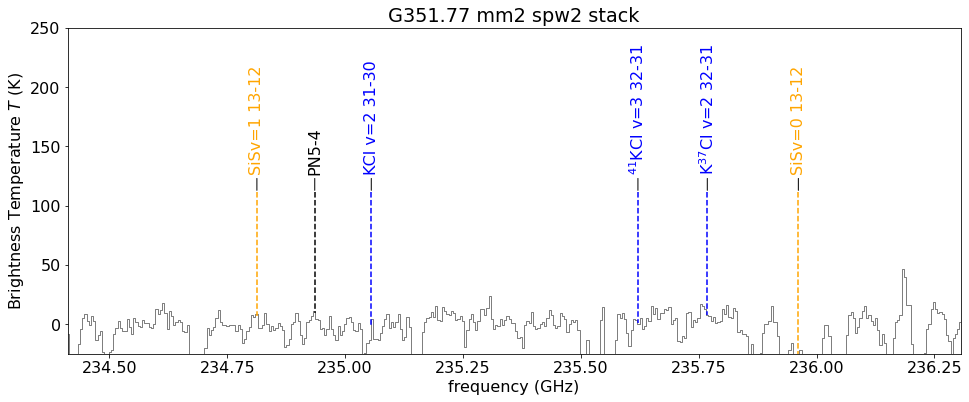

In [51]:
# changed from vcen=vcen to vcen=0 b/c these are stacked - TODO check this?
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymax=250, ymin=-25, yfrac=0.55)

rm spectra/figures/color_labels_G351_image_co1_smaller_stack_stack.png

rm spectra/figures/color_labels_G351_54_stack.png

In [52]:
ls spectra/figures/

color_labels_disk1_0_stack.png           disk1_2_stack.pdf
color_labels_disk1_1_stack.png           disk1_2_stack.png
color_labels_disk1_2_stack.png           disk1_3_stack.pdf
color_labels_disk1_3_stack.png           disk1_3_stack.png
color_labels_disk2_0_stack.png           disk2/
color_labels_disk2_1_stack.png           disk2_0_stack.pdf
color_labels_disk2_2_stack.png           disk2_0_stack.png
color_labels_disk2_3_stack.png           disk2_1_stack.pdf
color_labels_G351.77_mm1_0_stack.png     disk2_1_stack.png
color_labels_G351.77_mm1_1_stack.png     disk2_2_stack.pdf
color_labels_G351.77_mm1_2_stack.png     disk2_2_stack.png
color_labels_G351.77_mm1_3_stack.png     disk2_3_stack.pdf
color_labels_G351.77_mm1_spw0_stack.png  disk2_3_stack.png
color_labels_G351.77_mm1_spw1_stack.png  G351.77_mm1_0_stack.png
color_labels_G351.77_mm1_spw2_stack.png  G351.77_mm1_1_stack.png
color_labels_G351.77_mm1_spw3_stack.png  G351.77_mm1_2_stack.png
color_labels_G351.77_mm2_0_stack.png     G351.77_

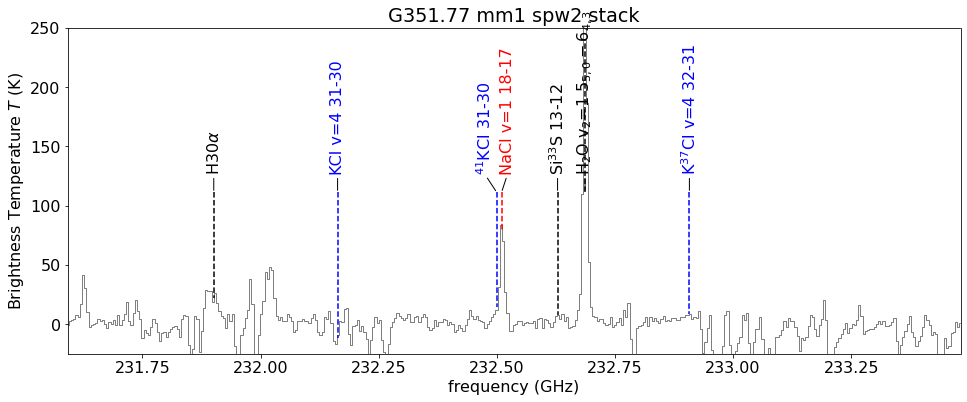

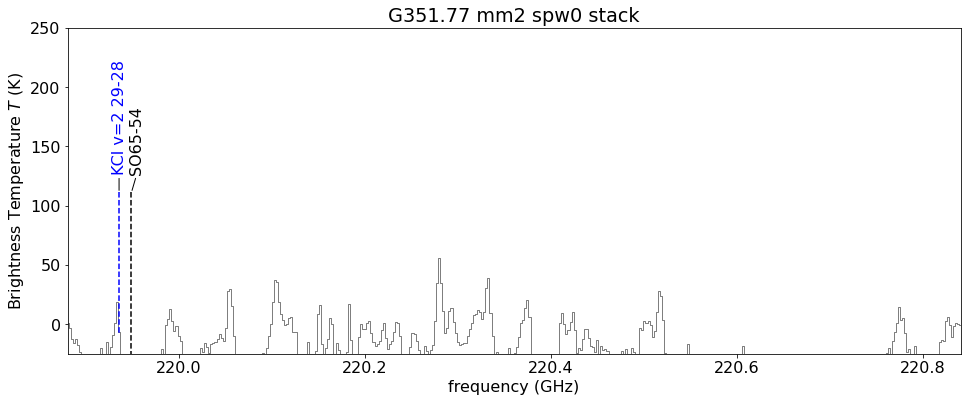

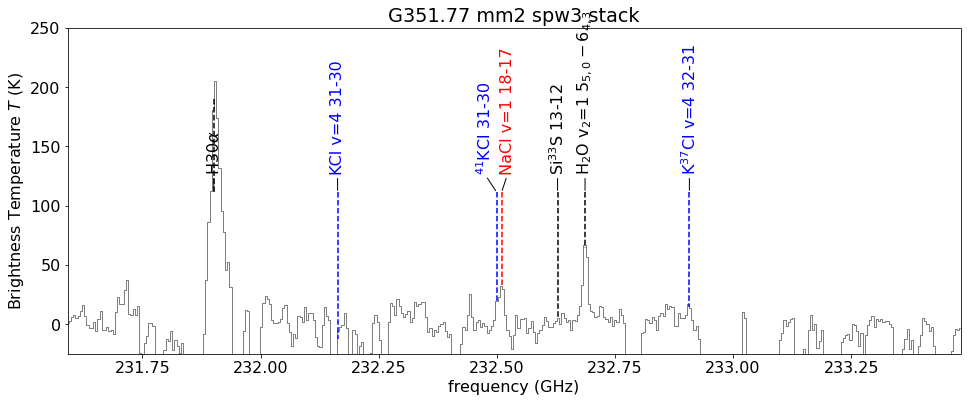

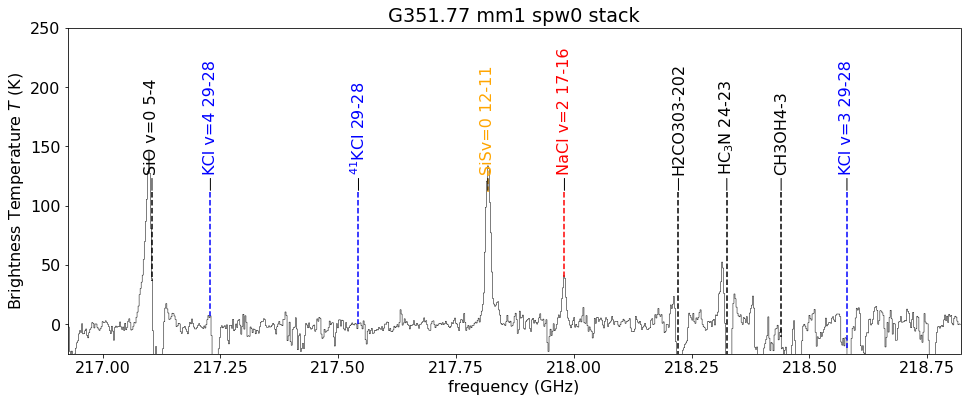

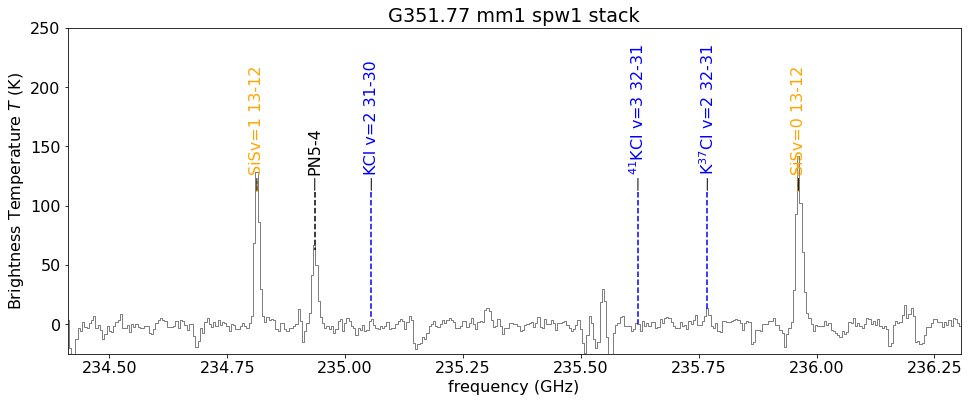

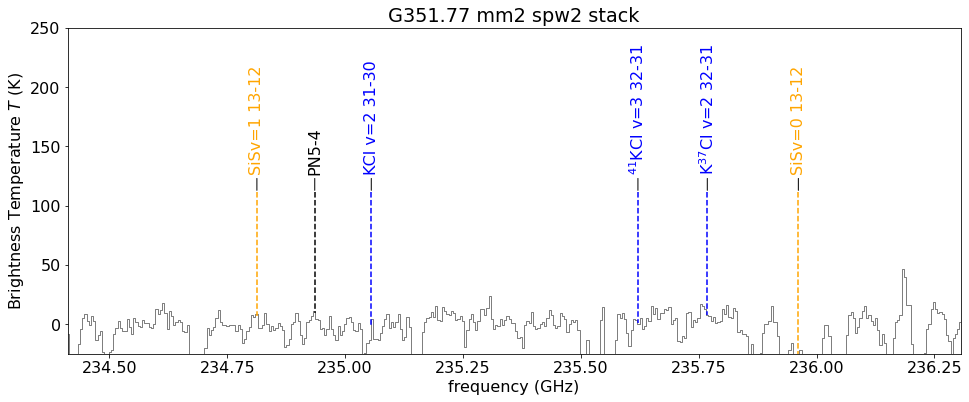

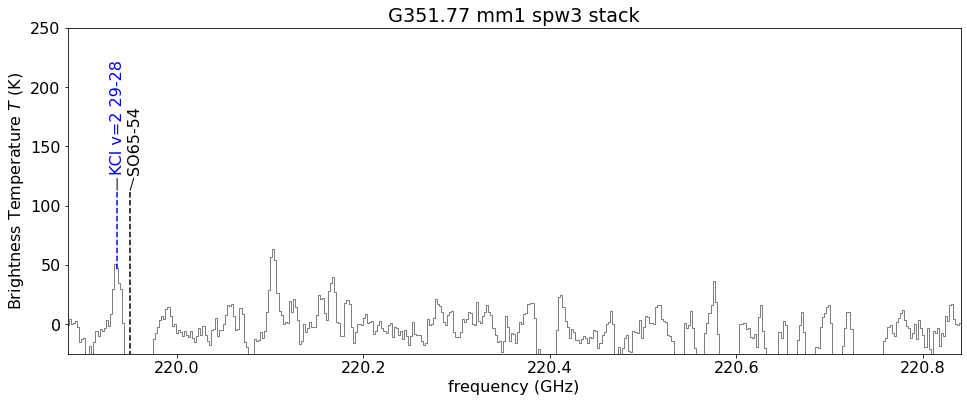

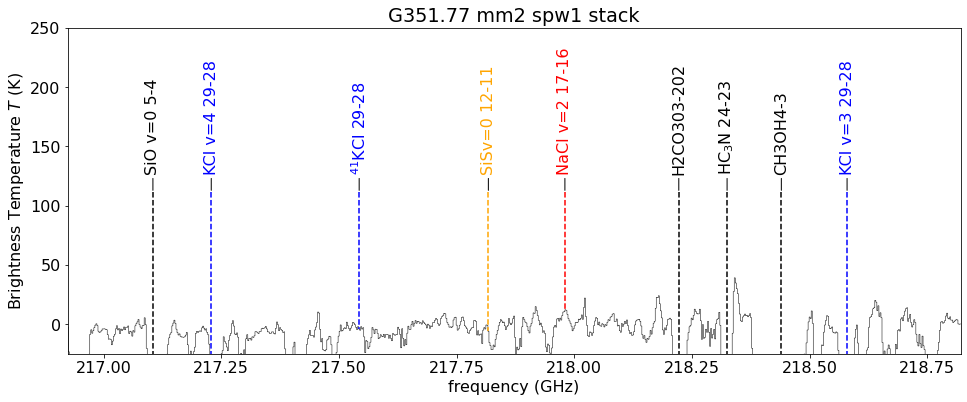

In [53]:
for fn in glob.glob('spectra/figures/color_labels_G351.77_mm[12]_spw[0-3]_stack.png'):
    display(Image(fn))

# Try to ID the lines from Beuther+ that were only tentative

In [54]:
from astroquery.splatalogue import Splatalogue

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str6,str19,float64,float64,int64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
SiSv=1,Silicon monosulfide,234.8129678,1.2e-06,--,--,13-12,-3.3503,39.13573,4.2,-3.66069,0.06,791.4773,1138.75273,799.30982,1150.02192,27.0,CDMS


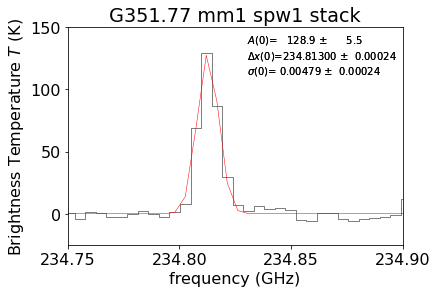

In [55]:
sp = stackspectra[6]
lx,ux = 234.75,234.9
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=150)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit #* (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=10000, energy_type='eu_k', chemical_name="monosulfide")


idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
0,PNv=0,Phosphorous nitride,234.9338834,4.07e-05,--,--,"N=5-4,J=5-5",-3.2004,1.50949,0.2,-4.68379,--,15.6739,22.55112,23.51045,33.8261,11.0,JPL
1,PNv=0,Phosphorous nitride,234.9338904,3.5e-06,--,--,"N=5-4,J=5-5",-3.1998,0.50297,0.067,-5.16108,--,15.6739,22.55112,23.51045,33.8261,11.0,CDMS
2,PNv=0,Phosphorous nitride,234.9356236,2.5e-06,--,--,"N=5-4,J=4-3",-1.911,9.77991,1.296,-3.78513,--,15.6739,22.55112,23.51051,33.82618,9.0,CDMS
3,PNv=0,Phosphorous nitride,234.935663,6.9e-05,234.93569,3e-05,5-4,0.0,37.71631,5.0,-3.28607,0.4,15.674,22.55126,23.51061,33.82633,11.0,SLAIM
4,PNv=0,Phosphorous nitride,--,--,234.93569,0.0001,"N=5-4,J=4-3",-1.9116,29.35108,3.889,-3.30784,0.4,15.6739,22.55112,23.51051,33.82619,9.0,JPL
5,PNv=0,Phosphorous nitride,--,--,234.93569,0.0001,"N=5-4,J=4-3",-1.8202,36.2263,4.8,-3.30359,0.4,15.6738,22.55097,23.51041,33.82604,11.0,JPL
6,PNv=0,Phosphorous nitride,--,--,234.93569,0.0001,"N=5-4,J=4-3",-1.73,44.58863,5.908,-3.28594,0.4,15.6739,22.55112,23.51051,33.82619,13.0,JPL
7,PNv=0,Phosphorous nitride,--,--,234.93569,0.0001,"N=5-4,J=4-3",-5.196,0.01525,0.002,-6.59224,0.4,15.6739,22.55112,23.51051,33.82619,9.0,JPL
8,PNv=0,Phosphorous nitride,234.9356952,2.4e-06,--,--,"N=5-4,J=5-4",-1.8196,12.07075,1.6,-3.78088,--,15.6738,22.55097,23.51041,33.82604,11.0,CDMS
9,PNv=0,Phosphorous nitride,234.9356952,2.4e-06,--,--,"N=5-4,J=5-4",-1.3247,37.72546,5.0,-3.28598,--,15.6739,22.55112,23.51051,33.82619,11.0,CDMS


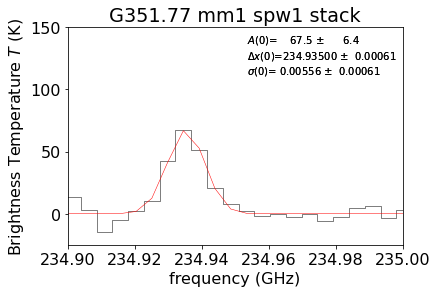

In [56]:
sp = stackspectra[6]
lx,ux = 234.9,235
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=150)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit #* (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
tbl = Splatalogue.query_lines(cen-dx, cen+dx, energy_max=10000, energy_type='eu_k', chemical_name='PN')
tbl.show_in_notebook(display_length=150)
#cen

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
0,SiSv=0,Silicon monosulfide,235.9611344,0.0010269,--,--,13-12,-1.7856,38.91171,12.1,-3.65683,--,47.2306,67.95391,55.10142,79.27819,27.0,JPL
1,SiSv=0,Silicon monosulfide,235.961352,3.5e-05,--,--,13-12,0.0,38.9077,13.0,-3.65686,0.39,47.231,67.95448,55.10182,79.27878,27.0,SLAIM
2,SiSv=0,Silicon monosulfide,235.9613634,1.2e-06,--,--,13-12,-1.796,39.1323,12.1,-3.65437,0.39,47.2306,67.95391,55.10142,79.2782,27.0,CDMS


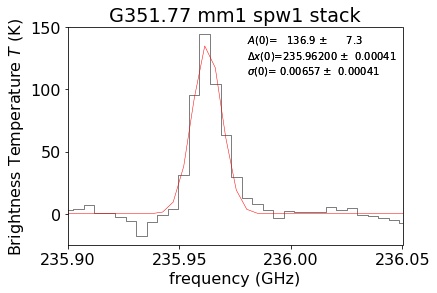

In [57]:
sp = stackspectra[6]
lx,ux = 235.9,236.05
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=150)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit #* (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
tbl = Splatalogue.query_lines(cen-dx, cen+dx, energy_max=10000, energy_type='eu_k', chemical_name='SiS')
tbl.show_in_notebook(display_length=150)

In [58]:
Splatalogue.query_lines(215*u.GHz, 236*u.GHz, energy_max=10000, energy_type='eu_k', chemical_name='Silicon monosulfide')

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str10,str19,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5
30Si36Sv=0,Silicon monosulfide,215.375214,2.2e-06,--,--,13-12,-1.9078,39.13289,12.2,-3.7733,--,43.1096,62.02474,50.29374,72.36106,27.0,CDMS
SiSv=2,Silicon monosulfide,215.6974524,1.3e-06,--,--,12-11,-4.9826,36.12166,1.3,-3.7727,--,1523.3659,2191.77112,1530.56079,2202.1229,25.0,CDMS
SiSv=2,Silicon monosulfide,215.697454,2.4e-05,--,--,12-11,0.0,35.9148,12.0,-3.77519,--,1523.366,2191.77126,1530.56089,2202.12305,25.0,SLAIM
SiSv=1,Silicon monosulfide,216.757599,2.3e-05,--,--,12-11,0.0,35.9148,12.0,-3.7688,0.046,784.247,1128.35001,791.47726,1138.75267,25.0,SLAIM
SiSv=1,Silicon monosulfide,216.7576028,1.1e-06,--,--,12-11,-3.4389,36.1232,3.9,-3.7663,0.046,784.2471,1128.35015,791.47736,1138.75281,25.0,CDMS
SiSv=0,Silicon monosulfide,217.8174727,0.0008004,--,--,12-11,-1.8741,35.91835,11.3,-3.76241,--,39.965,57.50039,47.23061,67.95392,25.0,JPL
SiSv=0,Silicon monosulfide,217.817644,3.2e-05,--,--,12-11,0.0,35.9148,12.0,-3.76244,0.66,39.965,57.50039,47.23061,67.95393,25.0,SLAIM
SiSv=0,Silicon monosulfide,--,--,217.817663,1e-05,12-11,-1.8845,36.12197,11.3,-3.75996,0.66,39.965,57.50039,47.23062,67.95393,25.0,CDMS
30Si34Sv=2,Silicon monosulfide,219.044747,3.4e-05,--,--,13-12,0.0,38.9077,13.0,-3.75379,--,1480.653,1493.17276,1491.07729,1503.68519,27.0,SLAIM


In [59]:
Splatalogue.query_lines(215*u.GHz, 236*u.GHz, energy_max=10000, energy_type='eu_k', chemical_name='PN')

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str5,str19,float64,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5
PNO,Phosphorous nitride,--,--,222.814568,3e-05,18-17,-1.8478,59.81635,18.0,-3.68162,--,63.1793,90.9004,70.61159,101.59375,37.0,CDMS
PNv=4,Phosphorous nitride,228.2495461,0.0001224,--,--,"N=5-4,J=5-5",-14.0856,1.47139,0.2,-4.7325,--,5224.5735,7516.95262,5232.18709,7527.9068,11.0,JPL
PNv=4,Phosphorous nitride,228.2512296,0.0001224,--,--,"N=5-4,J=4-3",-12.7968,28.61031,3.888,-3.35655,--,5224.5735,7516.95262,5232.18714,7527.90688,9.0,JPL
PNv=4,Phosphorous nitride,228.2512995,0.0001224,--,--,"N=5-4,J=5-4",-12.7054,35.31198,4.799,-3.3523,--,5224.5734,7516.95247,5232.18704,7527.90674,11.0,JPL
PNv=4,Phosphorous nitride,228.251336,0.0001224,--,--,"N=5-4,J=6-5",-12.6151,43.47325,5.908,-3.33455,--,5224.5735,7516.95262,5232.18715,7527.90689,13.0,JPL
PNv=4,Phosphorous nitride,228.2533269,0.0001224,--,--,"N=5-4,J=4-4",-14.0856,1.47134,0.2,-4.64534,--,5224.5734,7516.95247,5232.18711,7527.90684,9.0,JPL
PNv=3,Phosphorous nitride,229.9283352,6.62e-05,--,--,"N=5-4,J=5-5",-11.4076,1.48089,0.2,-4.72016,--,3943.1931,5673.34265,3950.86268,5684.37741,11.0,JPL
PNv=3,Phosphorous nitride,--,--,229.93013,0.0001,"N=5-4,J=4-3",-10.1188,28.79494,3.888,-3.3442,--,3943.1931,5673.34265,3950.86274,5684.3775,9.0,JPL
PNv=3,Phosphorous nitride,--,--,229.93013,0.0001,"N=5-4,J=4-3",-10.0274,35.53988,4.799,-3.33996,--,3943.193,5673.34251,3950.86264,5684.37735,11.0,JPL


In [60]:
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
from show_pv import show_pv
import imp
import show_pv
imp.reload(show_pv)
from show_pv import show_keplercurves, show_pv

In [61]:
import pvextractor

In [62]:
pathmm1angle = 130*u.deg
pathmm1 = pvextractor.Path(coordinates.SkyCoord([disk1[0].center.directional_offset_by(pathmm1angle,0.15*u.arcsec, ),
                                                 disk1[0].center.directional_offset_by(pathmm1angle-180*u.deg,0.15*u.arcsec, )]))
pvmm1 = pvextractor.extract_pv_slice(stackc, pathmm1)

leftmost: 1.1111111111112e-05 arcsec
rightmost: 7.222222222222799e-05 arcsec
endpoints_x = [0.20501111 0.22773838] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


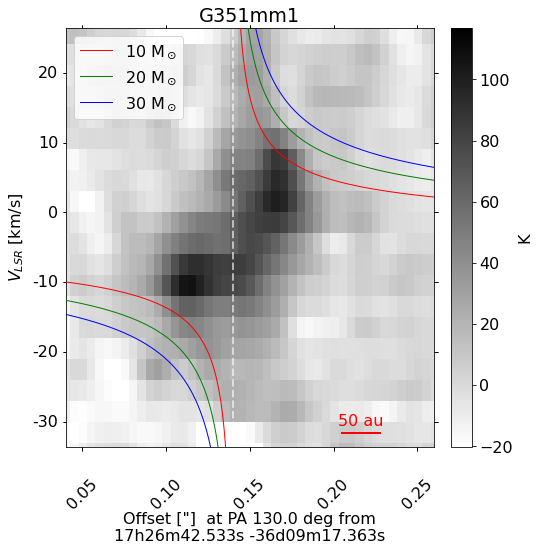

In [63]:
origin=0.14*u.arcsec
fig,ax,cb,con = show_pv(pvmm1.data, wcs.WCS(pvmm1.header), origin=origin,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(pvmm1.data, 3), imvmax=np.nanmax(pvmm1.data),
                        distance=distance,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, origin, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=distance,
                              )
pl.legend(loc='upper left')
#pl.gca().set_aspect(2.6)
pl.xlabel(f"Offset [\"]  at PA {pathmm1angle} from\n{disk1[0].center.to_string('hmsdms', precision=3)}")

pl.title("G351mm1")
pl.savefig("G351mm1_naclPV_withcolorcurves.png", bbox_inches='tight')
#pl.legend(loc='best')

In [64]:
pvmm1pn = pvextractor.extract_pv_slice(cubes[1].with_spectral_unit(u.km/u.s, rest_value=234.93569*u.GHz, velocity_convention='radio')
                                       .spectral_slab(vcen-40*u.km/u.s, vcen+40*u.km/u.s),
                                       pathmm1)

leftmost: 1.1111111111112e-05 arcsec
rightmost: 7.222222222222799e-05 arcsec
endpoints_x = [0.20501111 0.22773838] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


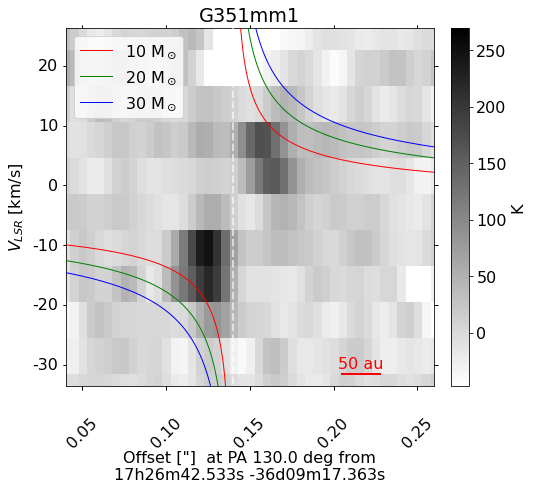

In [65]:
fig,ax,cb,con = show_pv(pvmm1pn.data, wcs.WCS(pvmm1pn.header), origin=origin,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(pvmm1pn.data, 3), imvmax=np.nanmax(pvmm1pn.data),
                        distance=distance,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, origin, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=distance,
                              )
pl.legend(loc='upper left')
pl.xlabel(f"Offset [\"]  at PA {pathmm1angle} from\n{disk1[0].center.to_string('hmsdms', precision=3)}")

pl.title("G351mm1")
pl.savefig("G351mm1_PNPV_withcolorcurves.png", bbox_inches='tight')
#pl.legend(loc='best')

In [66]:
pvmm1sis = pvextractor.extract_pv_slice(cubes[1].with_spectral_unit(u.km/u.s, rest_value=235.961352*u.GHz, velocity_convention='radio')
                                       .spectral_slab(vcen-40*u.km/u.s, vcen+40*u.km/u.s),
                                       pathmm1)

leftmost: 1.1111111111112e-05 arcsec
rightmost: 7.222222222222799e-05 arcsec
endpoints_x = [0.20501111 0.22773838] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


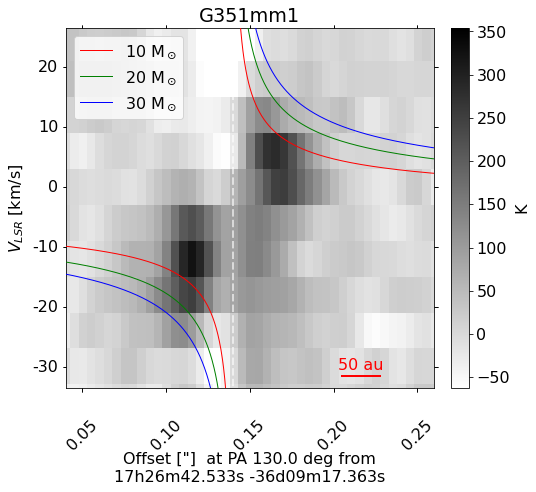

In [67]:
pvhdu = pvmm1sis
fig,ax,cb,con = show_pv(pvhdu.data, wcs.WCS(pvhdu.header), origin=origin,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(pvhdu.data, 3), imvmax=np.nanmax(pvhdu.data),
                        distance=distance,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, origin, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=distance,
                              )
pl.legend(loc='upper left')

pl.xlabel(f"Offset [\"]  at PA {pathmm1angle} from\n{disk1[0].center.to_string('hmsdms', precision=3)}")


pl.title("G351mm1")
pl.savefig("G351mm1_SiS1312PV_withcolorcurves.png", bbox_inches='tight')
#pl.legend(loc='best')

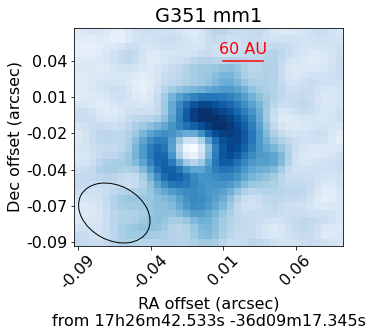

In [68]:
m0 = (cubes[1].with_spectral_unit(u.km/u.s, rest_value=235.961352*u.GHz, velocity_convention='radio')
      .spectral_slab(vcen-25*u.km/u.s, vcen+25*u.km/u.s).moment0())

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

dp_60 = (60*u.au / pixscale_au).decompose()

pl.title("G351 mm1")
pl.plot([20, 20+dp_60], [25,25], color='r')
pl.text(20 + dp_60/2, 26, f'60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xc,yc = 18,18

xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xtlocs-xc)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-yc)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)

offset_loc = m0.wcs.celestial.pixel_to_world(xc,yc)


ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("G351disk1_SiS13-12_mom0_ticks.png", bbox_inches='tight', dpi=300)

In [69]:
pathmm2angle = -34*u.deg
pathmm2 = pvextractor.Path(coordinates.SkyCoord([disk2[0].center.directional_offset_by(pathmm2angle,0.15*u.arcsec, ),
                                                 disk2[0].center.directional_offset_by(pathmm2angle-180*u.deg,0.15*u.arcsec, )]))
pvmm2 = pvextractor.extract_pv_slice(stack2, pathmm2)

leftmost: 2.3611111111112998e-05 arcsec
rightmost: 5.6944444444449e-05 arcsec
endpoints_x = [0.15502361 0.17775088] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


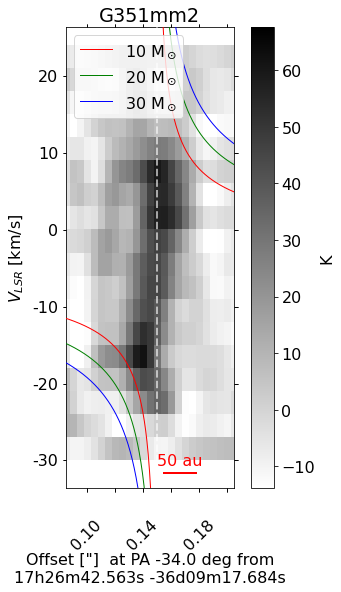

In [70]:
fig,ax,cb,con = show_pv(pvmm2.data, wcs.WCS(pvmm2.header), origin=0.15*u.arcsec,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(pvmm2.data, 3), imvmax=np.nanmax(pvmm2.data),
                        distance=distance,
                        xoffset_label=0.155*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.15*u.arcsec, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=distance,
                              )
pl.legend(loc='upper left')

pl.xlabel(f"Offset [\"]  at PA {pathmm2angle} from\n{disk2[0].center.to_string('hmsdms', precision=3)}")


pl.title("G351mm2")
pl.savefig("G351mm2_naclPV_withcolorcurves.png", bbox_inches='tight')
#pl.legend(loc='best')